# Set Up

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%load_ext lab_black

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sm
import ppscore as pps
import scipy

sys.path.append("..")
from src.data import make_dataset
from src.helpinghand import plot_series

output_dirpath = r"..\\data\\raw"

In [2]:
# get the data we need
key = "ELECTRICITY_ACTUALS"
raw_elec_volume_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_elec_volume_path):
    print("Raw data doesn't exist, so gathering it")
    create_electricity_actuals_dataset(start, end, output_dirpath)

elec = make_dataset.prepare_electricity_actuals(raw_elec_volume_path)
daily_elec_averages = (
    elec[["CCGT", "OCGT"]].fillna(method="ffill").sum(axis=1)
)  # a better way of fillna would be to take the average of the before and after
daily_elec_GWH = daily_elec_averages * 24 / 1000  # convert to a total day GWH

In [3]:
# get the data we need
key = "GAS_VOLUME"
raw_gas_volume_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_volume_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)

gas_volume = make_dataset.prepare_gas_data(raw_gas_volume_path).rename(
    {"VALUE": "VOLUME"}, axis=1
)
# kWH

gas_volume = make_dataset.map_to_sites(gas_volume)


key = "GAS_CV"
raw_gas_cv_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_cv_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)

gas_cv = make_dataset.prepare_gas_data(raw_gas_cv_path).rename({"VALUE": "CV"}, axis=1)
# kWH

gas_cv = make_dataset.map_to_sites(gas_cv)

gas_energy = gas_volume.merge(
    gas_cv, left_on=["GAS_DAY", "SITE"], right_on=["GAS_DAY", "SITE"]
)

gas_energy["VOLUME_MULT_CV"] = gas_energy["VOLUME"] * gas_energy["CV"]
gas_energy["ENERGY_GWH"] = gas_energy["VOLUME_MULT_CV"] / 3.6

# calculate the daily average energy for all Powerstations
daily_gas_energy = gas_energy.groupby("GAS_DAY")["ENERGY_GWH"].sum().tz_localize(None)

In [4]:
# get the data we need
df = pd.DataFrame({"ELECTRICITY": daily_elec_GWH, "GAS": daily_gas_energy}).dropna()
df["EFFICIENCY"] = df["ELECTRICITY"] / df["GAS"]


df["YEAR"] = df.index.year
df["MONTH"] = df.index.month
df.head()

,ELECTRICITY,GAS,EFFICIENCY,YEAR,MONTH
GAS_DAY,,,,,
2016-03-14,362.7460,665.422143,0.545137,2016,3
2016-03-15,392.7550,708.304806,0.554500,2016,3
2016-03-16,393.2615,716.165089,0.549121,2016,3
2016-03-17,406.4755,739.237716,0.549858,2016,3
2016-03-18,407.2865,724.488819,0.562171,2016,3


# Does the amount of electricity produced impact the efficiency?

One hypothesis could be that powerstations have an optimum output level for which they are most efficient. Unfortunately we don't have the individual powerstation data, so can't do anything too conclusive, but we can look at this on a global scale. 

Simply visualising the data, we see the clear relationship between gas and electricity, centring the efficiency around 55%. Focussing in on the plot of Electricity vs Efficiency we see a triangle type shape, high electricity outputs have a centred efficiency, and low electricity outputs have a larger spread. This could be due to a lack of data at the larger electricity outputs, or another factor like season coming in to play.

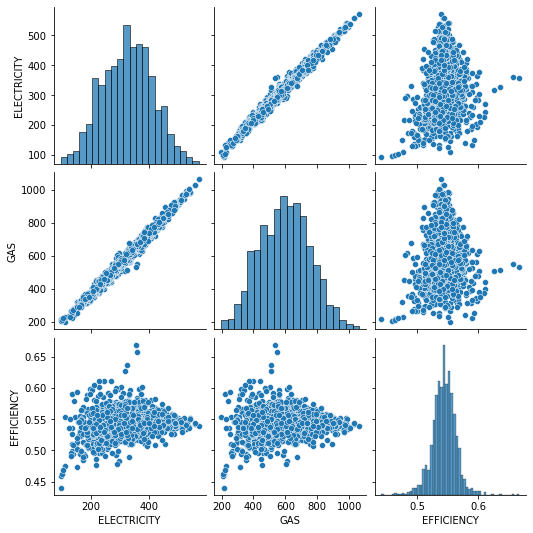

In [5]:
sns.pairplot(df.drop(["MONTH", "YEAR"], axis=1))
plt.show()

# Does Efficiency change seasonally?

In time series analysis, "seasonally" is used generically to mean patterns in data with a certain period. For example we can have yearly seasonality (winter effects) with a period of 365 days, as well as monthly seasonality (month end) with a period of 30 days and weekly seasonality (weekend effects) with a period of 7 days. From first glance, there doesn't seem to be any seasonality in there. If we were looking to simply remove the seasonality and not understand it fully, we would difference the data (look at the difference between today and yesterday).

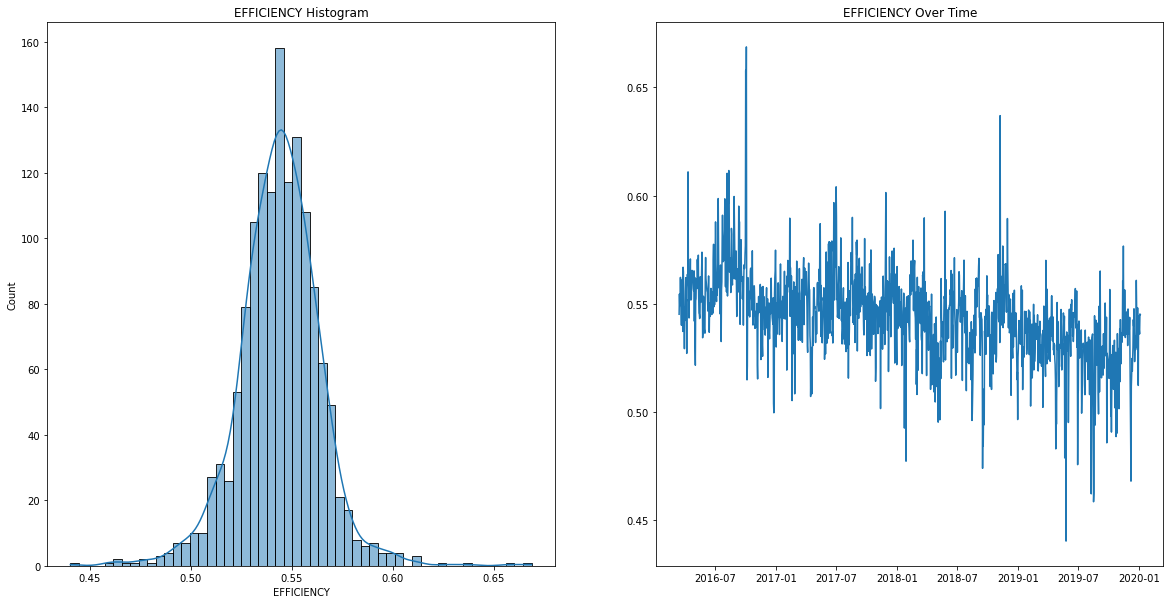

In [6]:
plot_series(df["EFFICIENCY"])

We can begin to decompose any seasonal affects by doing autocorrelation analysis and comparing each value with a lagged version of itself i.e. compare today's value with the value from last week. We see some slight peaking every 7th day which indicates that there is some weekly seasonality in there, but primarily the highest autocorrelation is with yesterday. This means yesterday is similar to today in general.

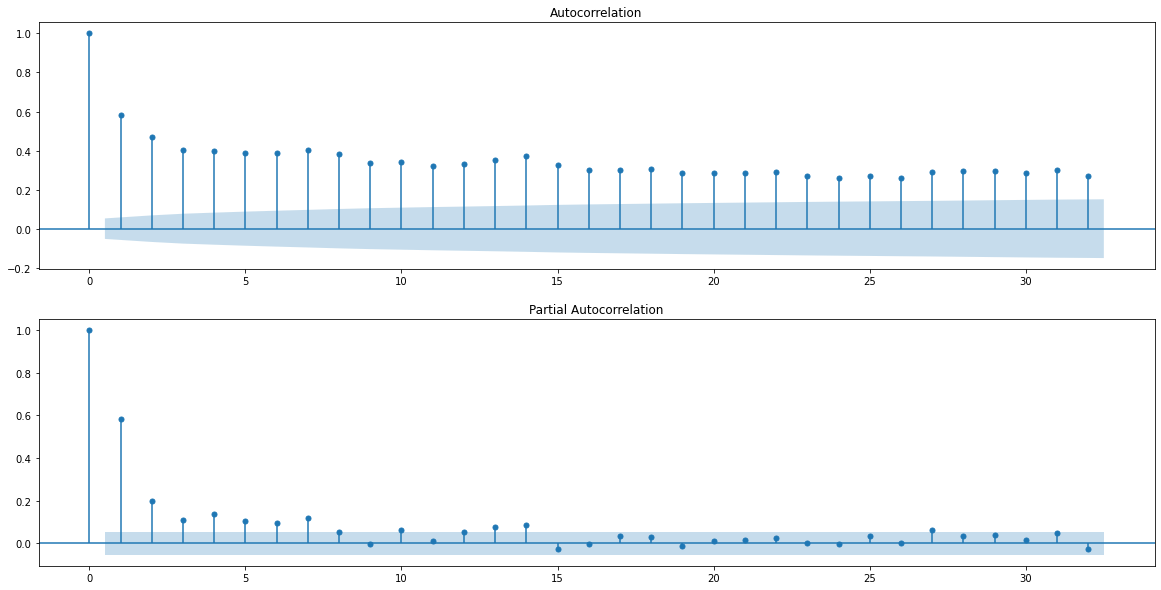

In [7]:
from statsmodels.graphics import tsaplots

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

lags = None

a = tsaplots.plot_acf(df["EFFICIENCY"], lags=lags, ax=ax[0])
b = tsaplots.plot_pacf(df["EFFICIENCY"], lags=lags, ax=ax[1])

A more complex method is to build an additive model to understand various seasonal components, the facebook prophet library does this very well but let's start with a simple seasonal_decompose. This doesn't show much other than a slight downward trend.

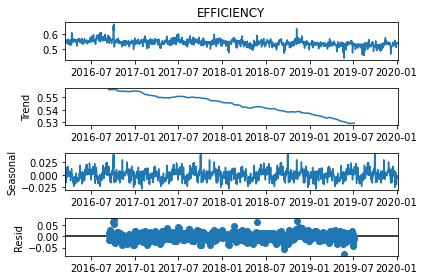

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonality = seasonal_decompose(df["EFFICIENCY"], model="additive", period=365)

a = seasonality.plot()

In [9]:
# from prophet import Prophet
#
# proph_data = df["EFFICIENCY"].reset_index()
# proph_data = proph_data.rename({"GAS_DAY" : "ds", "EFFICIENCY" : "y"}, axis=1)
#
# m = Prophet()
# m.fit()
#
# future = m.make_future_dataframe(periods=365)
#
# forecast = m.predict(future)
#
#
# fig2 = m.plot_components(forecast)

To further examine seasonality, we could explore a bunch of different things:
- More detailed seasonal decomposition
- Adding seasonal features (like day of the week, month, season) to the data to visualise and test
- do a fourier transform and examine its components

I'm going to try something a little out the box, and use the number of daylight hours to represent seasonality and examine any correlation there.

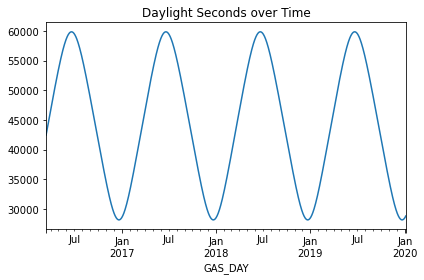

In [10]:
from astral import LocationInfo
from astral.sun import sun


# set location to get sun data for
city = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)


date_list = df.index

days = []
for adate in date_list:
    day = sun(city.observer, date=adate)
    day = pd.DataFrame(day, index=[adate.date()])
    days.append(day)

sundata = pd.concat(days)
sundata.index.name = "GAS_DAY"
sundata["DAYLIGHT_HOURS"] = sundata["sunset"] - sundata["sunrise"]
sundata["DAYLIGHT_SECONDS"] = sundata["DAYLIGHT_HOURS"].dt.total_seconds()

df = df.merge(
    sundata["DAYLIGHT_SECONDS"], how="left", left_index=True, right_index=True
)

fig, ax = plt.subplots()

df["DAYLIGHT_SECONDS"].plot(ax=ax)
plt.title("Daylight Seconds over Time")
plt.tight_layout()
plt.show()

Looking at the scaled data over time, we can see that the electricity and gas usage (which is linked to electricity demand) is inversely correlated with the daylight hours, i.e. when there is more daylight there is less electricity demand - which makes sense. There doesn't seem to be much relationship visible with efficiency.

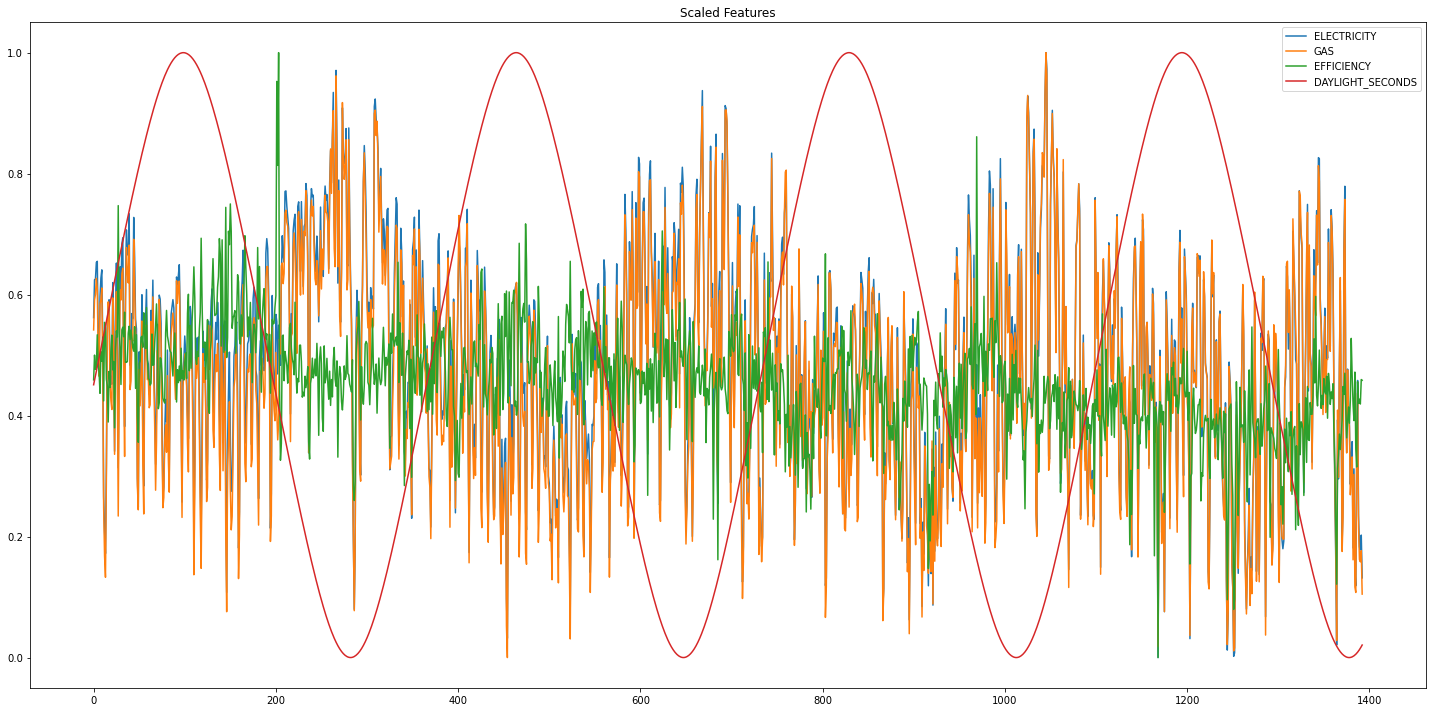

In [11]:
from sklearn.preprocessing import MinMaxScaler

cols = ["ELECTRICITY", "GAS", "EFFICIENCY", "DAYLIGHT_SECONDS"]
x = df[cols].values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=cols)

fig, ax = plt.subplots(figsize=(20, 10))

df_scaled.plot(ax=ax)
plt.title("Scaled Features")
plt.tight_layout()
plt.show()

The correlation matrix backs up our visual observation that there could be global inverse correlation between Electricity/Gas and season, but not much for efficiency.

In [13]:
df.drop(["MONTH", "YEAR"], axis=1).corr()

,ELECTRICITY,GAS,EFFICIENCY,DAYLIGHT_SECONDS
ELECTRICITY,1.000000,0.992647,0.208363,-0.313028
GAS,0.992647,1.000000,0.093784,-0.320732
EFFICIENCY,0.208363,0.093784,1.000000,0.043402
DAYLIGHT_SECONDS,-0.313028,-0.320732,0.043402,1.000000


# Does Temperature interact with Efficiency?

Temperature could have a few affect efficiency for a few different reasons:

1. the [Ideal Gas Law](https://en.wikipedia.org/wiki/Ideal_gas_law) tells us that Pressure * Volume/Temperature should be constant. This means if Temperature goes up, Pressure or Volume must go up too. This may mean our measurements of gas volume (thus gas energy and powerstations efficiency) are altered.
2. Many of our powerstation plants have heat recovery systems, it could be that ambient temperature affects these thermal recovery processes.
3. Warmer temperatures may reduce the energy dissipated in heating the gas
3. The resistance of an electrical conducter [increases](https://en.wikipedia.org/wiki/Electric_power_transmission) with temperature, meaning we may lose electrical energy in transportation, reducing the measured efficiency.

A lot of these are theories and ideas, and will depend on the specifics of measuring practices and power plant design. Without further knowledge, let's see if we can see anything in our data!

In [14]:
key = "temperature"
raw_temp_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_temp_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)


temperature = make_dataset.prepare_gas_data(
    raw_temp_path, keep_powerstations_only=False,
)
temperature = temperature.groupby("GAS_DAY")["VALUE"].mean().rename("TEMPERATURE")

df = df.merge(temperature, how="left", left_index=True, right_index=True)

The first thing we note when looking at the temperature is we have a block of missing data! The other is that the temperature doesn't go too high or too low, likely as it's a UK average.

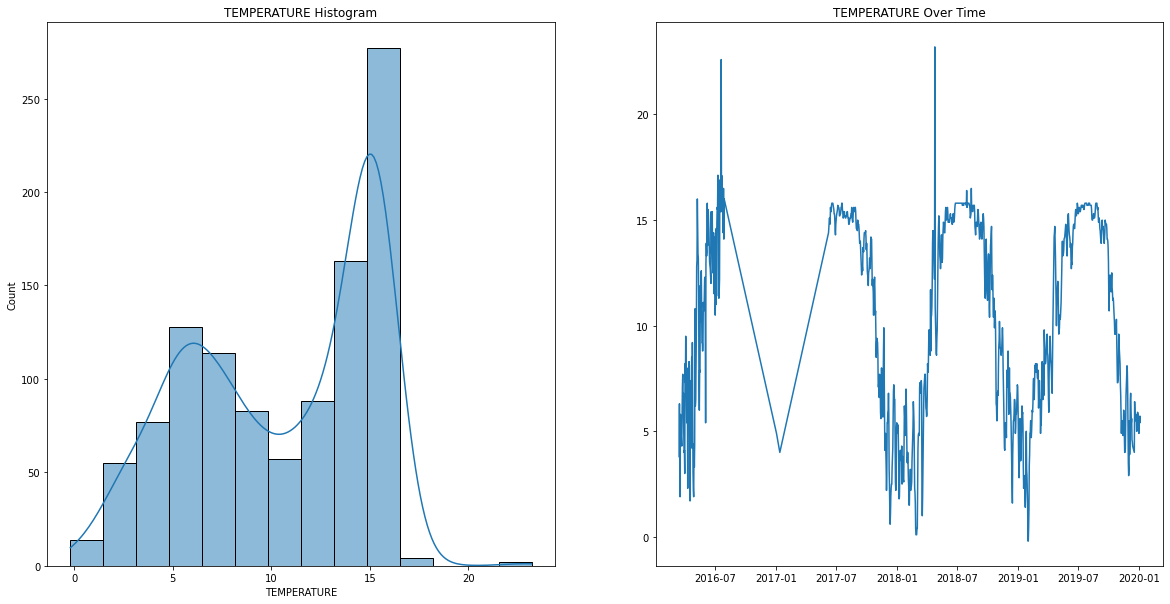

In [15]:
plot_series(temperature)

If again we look at the scaled data, it's a bit of a mess, but we can see temperature is correlated with season (no prizes there). What's nice to see is that temperature is more correlated with Electricity/Gas than season, indicating season may just be a proxy for weather when it comes to demand (which makes sense!). Unfortunately, this doesn't help us with our efficiency analysis.

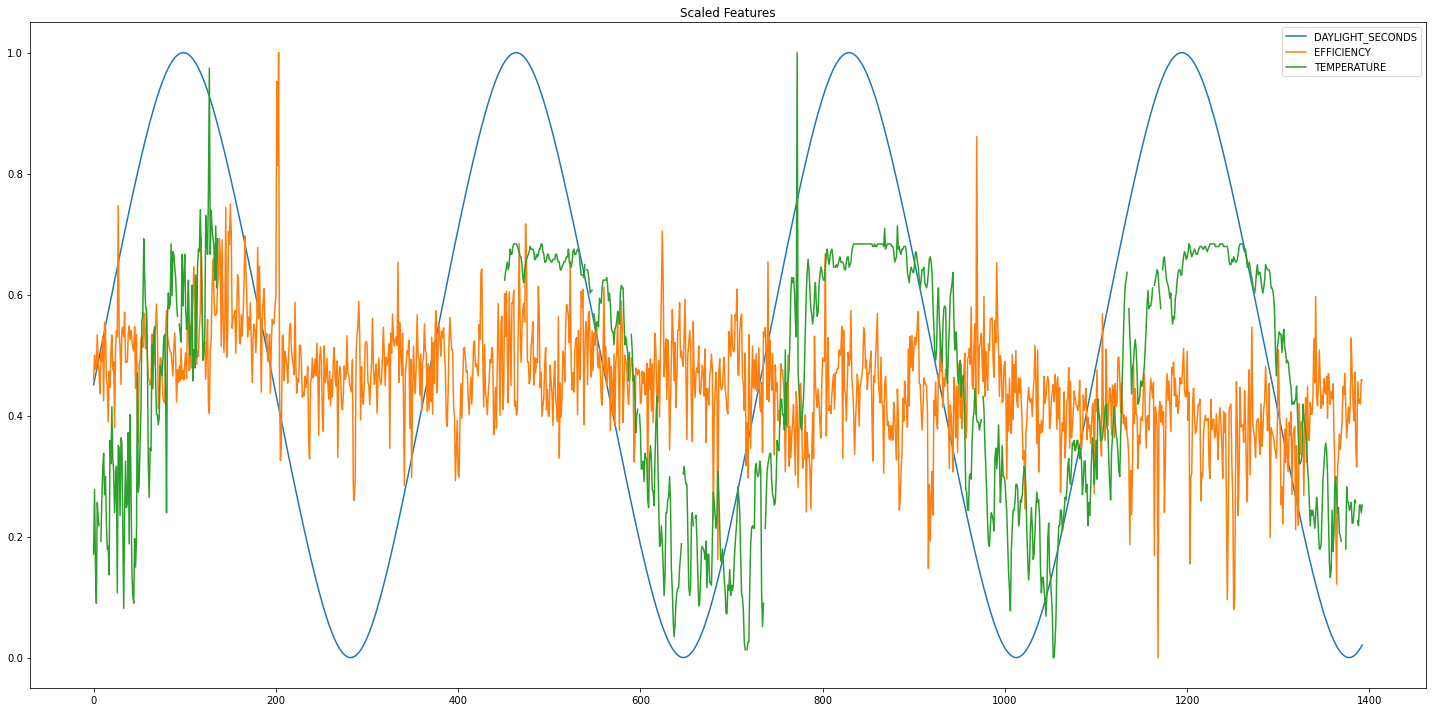

In [16]:
cols = ["DAYLIGHT_SECONDS", "EFFICIENCY", "TEMPERATURE"]
x = df[cols].values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=cols)

fig, ax = plt.subplots(figsize=(20, 10))

df_scaled.plot(ax=ax)
plt.title("Scaled Features")
plt.tight_layout()
plt.show()

Again, our correlation matrix backs up our visual interpretation.

In [17]:
df.drop(["MONTH", "YEAR"], axis=1).corr()

,ELECTRICITY,GAS,EFFICIENCY,DAYLIGHT_SECONDS,TEMPERATURE
ELECTRICITY,1.000000,0.992647,0.208363,-0.313028,-0.380285
GAS,0.992647,1.000000,0.093784,-0.320732,-0.376124
EFFICIENCY,0.208363,0.093784,1.000000,0.043402,-0.075438
DAYLIGHT_SECONDS,-0.313028,-0.320732,0.043402,1.000000,0.773451
TEMPERATURE,-0.380285,-0.376124,-0.075438,0.773451,1.000000


We can look at this in various ways, statistically with correlation analysis, or a multitude of various statistical tests but sometimes the best way to look at things is to simply visualise the data. Looking at the data we don't see any clear relationships between temperature and efficiency.

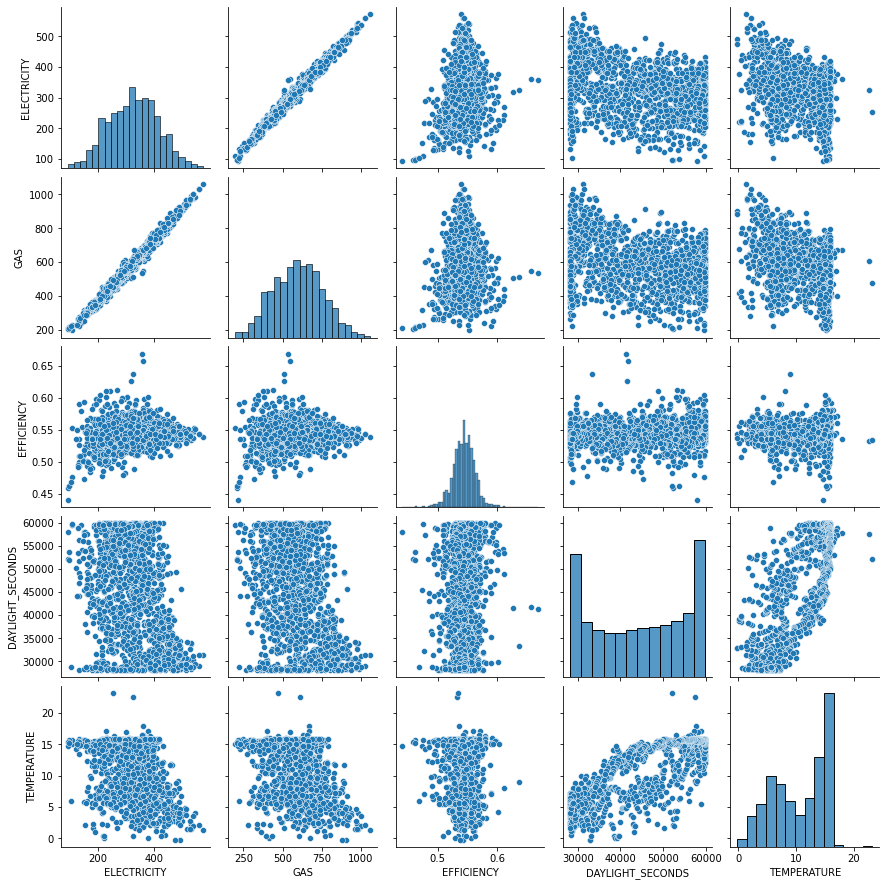

In [18]:
sns.pairplot(df.drop(["MONTH", "YEAR"], axis=1))
plt.show()

The same holds for looking at the change in efficiency, and the change in temperature. If there's an increase in temperature, it doesn't seem to effect the change in efficiency.

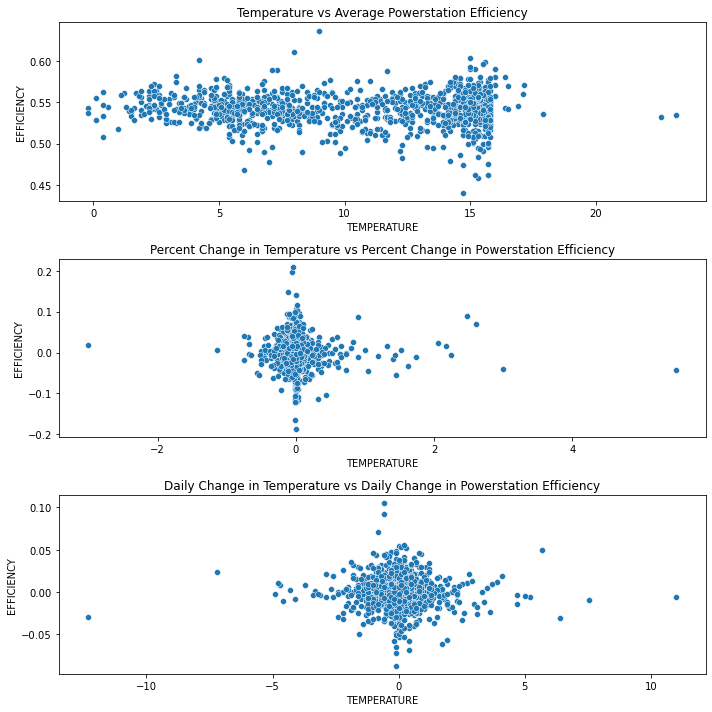

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.scatterplot(data=df, x="TEMPERATURE", y="EFFICIENCY", ax=ax[0])
ax[0].set_title("Temperature vs Average Powerstation Efficiency")

sns.scatterplot(data=df.pct_change(), x="TEMPERATURE", y="EFFICIENCY", ax=ax[1])
ax[1].set_title(
    "Percent Change in Temperature vs Percent Change in Powerstation Efficiency"
)

sns.scatterplot(data=df.diff(), x="TEMPERATURE", y="EFFICIENCY", ax=ax[2])
ax[2].set_title(
    "Daily Change in Temperature vs Daily Change in Powerstation Efficiency"
)

plt.tight_layout()
plt.show()

# Is on-site renewable generation masking our efficiency?

In "1-why-are-gas-fired-powerstations-important" we showed that the electricity produced by powerstations is often to counterbalance renewable production.

In "2-how-efficient-are-gas-fired-powerstations" we saw some variation in our estimates for each site's effiency, and hypothesised this could be due to on-site renewable generation altering our perceptions of efficiency. This would mean on high wind days we may get an increase in efficiency and vice versa.

Can we show this at a global scale?


In [20]:
daily_wind_elec_averages = (
    elec[["WIND"]].fillna(method="ffill").sum(axis=1)
)  # a better way of fillna would be to take the average of the before and after
daily_wind_GWH = daily_wind_elec_averages * 24 / 1000  # convert to a total day GWH

df = df.merge(daily_wind_GWH.rename("WIND"), left_index=True, right_index=True)

Wind looks very interesting, as we have seen an expansion in the number of wind generation sites over the years there is a general upwards trend in generation, as well as seasonal component. We may have to remove the trend if we are to test our hypothesis fully but let's leave it for now.

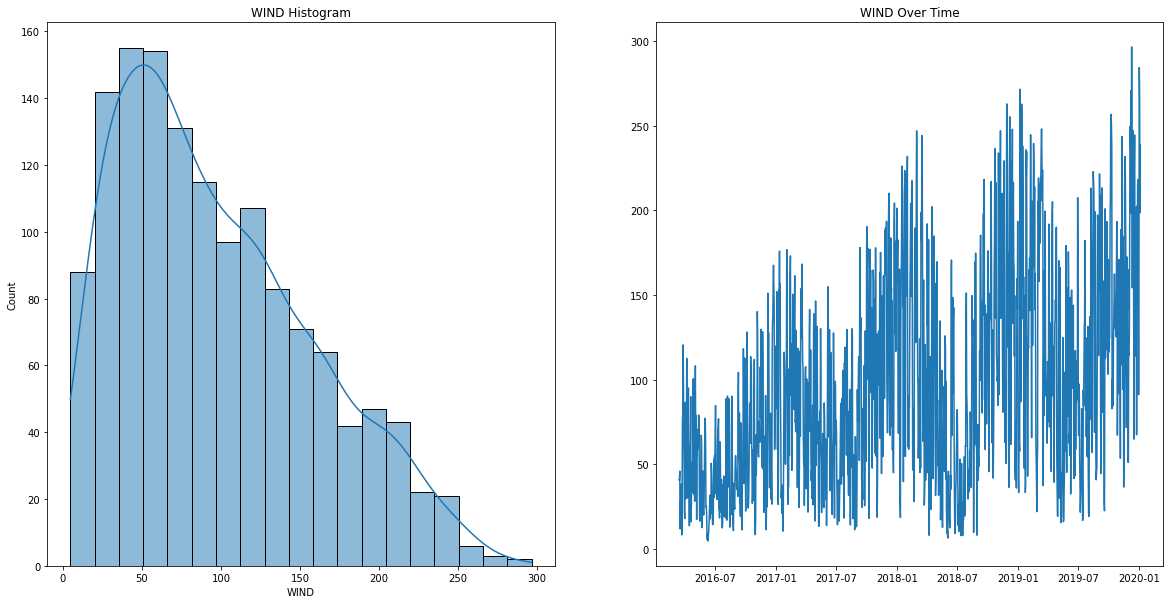

In [21]:
plot_series(df["WIND"])

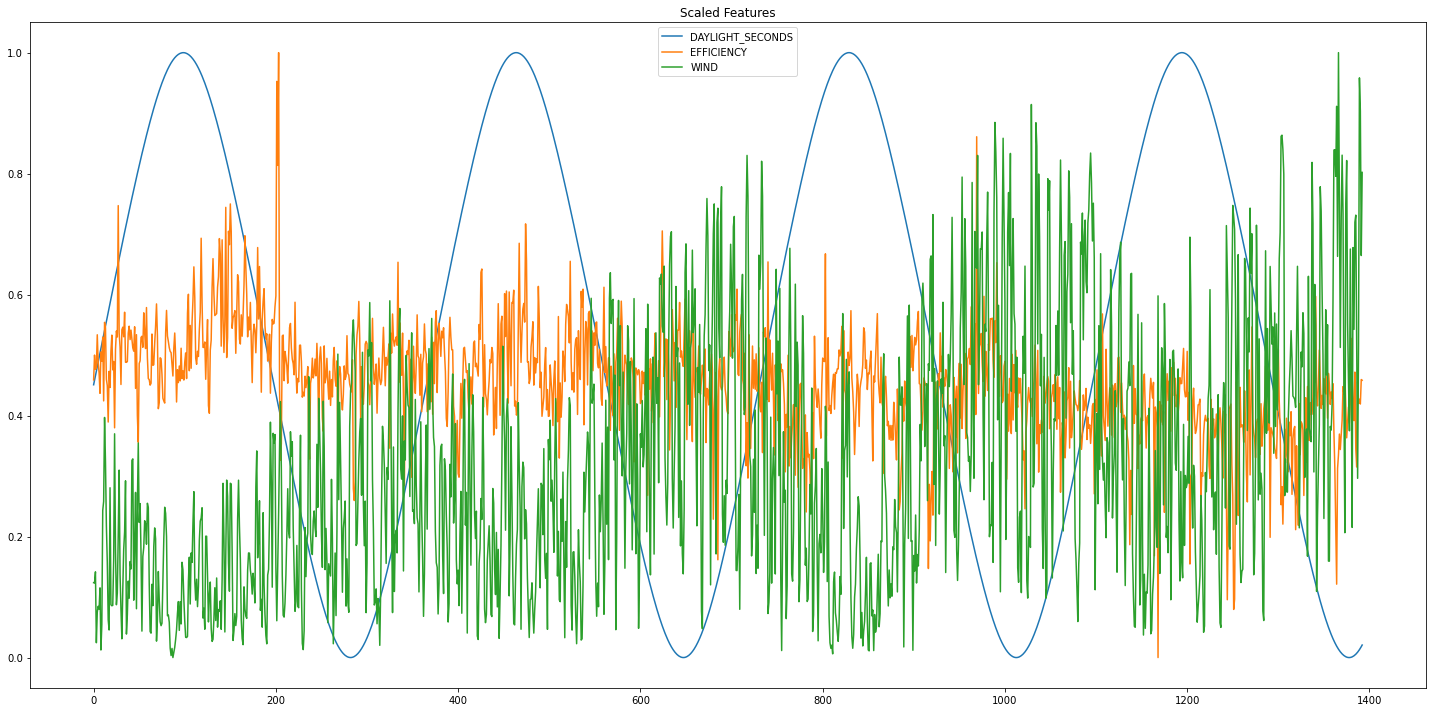

In [22]:
cols = ["DAYLIGHT_SECONDS", "EFFICIENCY", "WIND"]
x = df[cols].values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=cols)

fig, ax = plt.subplots(figsize=(20, 10))

df_scaled.plot(ax=ax)
plt.title("Scaled Features")
plt.tight_layout()
plt.show()

There seems to be a global correlation, the trend of efficiency decreasing and the trend of installed wind capacity increasing.

In [30]:
df.corr()

,ELECTRICITY,GAS,EFFICIENCY,YEAR,MONTH,DAYLIGHT_SECONDS,TEMPERATURE,WIND
ELECTRICITY,1.000000,0.992647,0.208363,-0.168251,-0.082283,-0.313028,-0.380285,-0.462259
GAS,0.992647,1.000000,0.093784,-0.106389,-0.087045,-0.320732,-0.376124,-0.431064
EFFICIENCY,0.208363,0.093784,1.000000,-0.503640,0.009029,0.043402,-0.075438,-0.343533
YEAR,-0.168251,-0.106389,-0.503640,1.000000,-0.118868,-0.077919,-0.066152,0.432597
MONTH,-0.082283,-0.087045,0.009029,-0.118868,1.000000,-0.219620,0.183510,0.074959
DAYLIGHT_SECONDS,-0.313028,-0.320732,0.043402,-0.077919,-0.219620,1.000000,0.773451,-0.432760
TEMPERATURE,-0.380285,-0.376124,-0.075438,-0.066152,0.183510,0.773451,1.000000,-0.356023
WIND,-0.462259,-0.431064,-0.343533,0.432597,0.074959,-0.432760,-0.356023,1.000000


# Does Calorific Value affect Efficiency?

Calorific value (CV) is a measure of heating power and is dependent upon the composition of the gas. The CV refers to the amount of energy released when a known volume of gas is completely combusted under specified conditions. The CV of gas, which is dry, gross and measured at standard conditions of temperature (15oC) and pressure (1013.25 millibars), is usually quoted in megajoules per cubic metre (MJ/m3). Gas passing through our pipeline system has a CV of 37.5 MJ/m3 to 43.0 MJ/m3.

Calorific value is part of how we calculate energy, CV * Volume.

[https://www.nationalgrid.com/uk/gas-transmission/data-and-operations/calorific-value-cv]

In [41]:
gas_cv = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_CV.csv"
)
gas_cv = gas_cv[gas_cv["VALUE"] != 0]
daily_gas_cv = gas_cv.groupby("GAS_DAY")["VALUE"].mean().tz_localize(None)
df = df.merge(daily_gas_cv.rename("CV"), how="left", left_index=True, right_index=True)

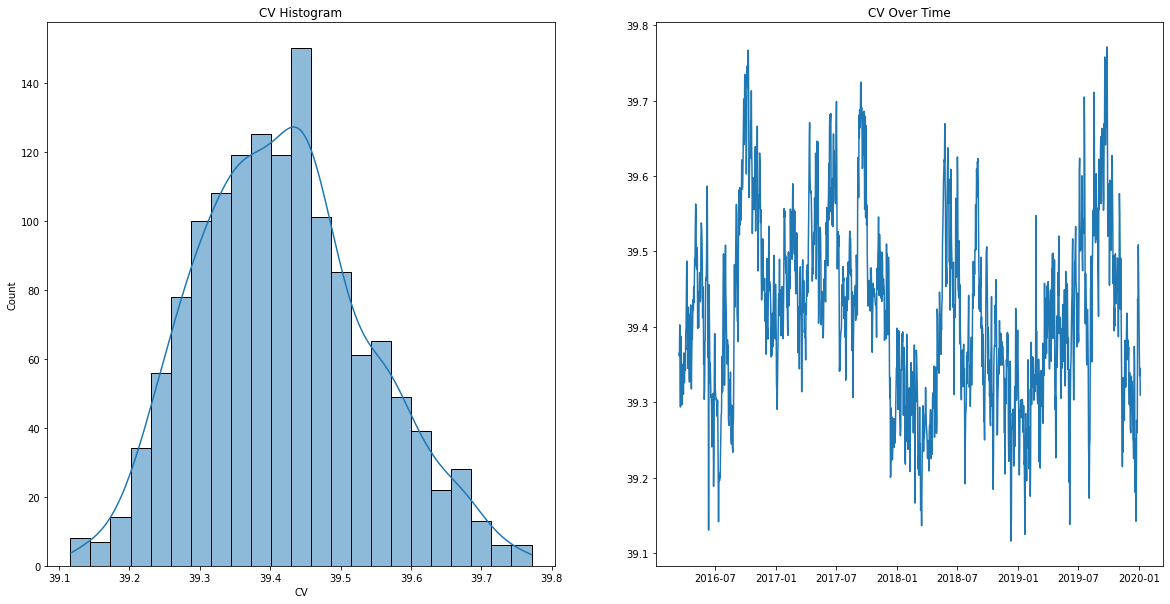

In [42]:
plot_series(df["CV"])

There doesn't seem to be much relationship between Calorific Value and Efficiency.

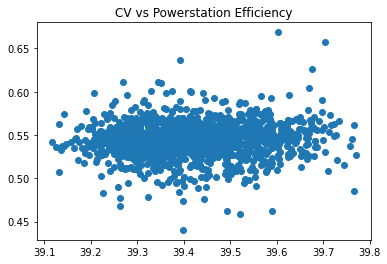

In [44]:
plt.scatter(df["CV"], df["EFFICIENCY"])
plt.title("CV vs Powerstation Efficiency")
plt.show()

# Can we model efficiency?

We've had a bit of an exploration of different factors that could contribute to efficiency.

1. It could be that low electricity generation levels increase variability in efficiency
2. There seems to be a small decreasing trend in efficiency over time
3. Temperature doesn't look to effect efficiency
4. Wind generation might affect efficiency
5. Calorific Value doesn't seem to have an impact

Can we predict efficiency based on some of these explored areas, without knowing our exact gas energy?

To ensure we can test our model, we'll split our data in to three sets: training, validation and testing. We'll do this without shuffling to preserve the time series and ensure no data leakage, so let's do it by year. We could do some more advanced TimeSeriesSplit cross validation for better scoring but let's keep it simple for now and use the mean absolute error as our primary performance metric.

In [70]:
df["YEAR"].value_counts().sort_index()

2016    293
2017    365
2018    365
2019    365
2020      5
Name: YEAR, dtype: int64

In [71]:
df_train = df[df["YEAR"] < 2018]
df_valid = df[df["YEAR"] == 2018]
df_test = df[df["YEAR"] > 2018]

## Baseline

Let's choose a simple baseline to start with, let's use yesterday's efficiency as our prediction for today's efficiency.

In [54]:
def naive(timeseries, lag):
    """
    Baseline prediction of using a certainday's lag value as our prediction
    """
    return timeseries.shift(periods=lag, freq="D")

This does quite a good job on our training dataset, as seen by our [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) metric.

In [89]:
from sklearn.metrics import mean_absolute_error


def prepare_for_metrics(y_true, y_pred):

    data = pd.concat([y_true.rename("Y"), y_pred.rename("PREDICTION")], axis=1).dropna()

    return data["Y"], data["PREDICTION"]


y, pred = prepare_for_metrics(df["EFFICIENCY"], naive(df_train["EFFICIENCY"], 1))

baseline_train_mae = mean_absolute_error(y, pred)
print(f"Our baseline MAE is {baseline_train_mae:.4f}")

Our baseline MAE is 0.0132


There's a few things we can check to test the fit of a model. The first is ensuring that there is a linear relationship between our predictions and the actuals, if not then maybe our model isn't the right kind.

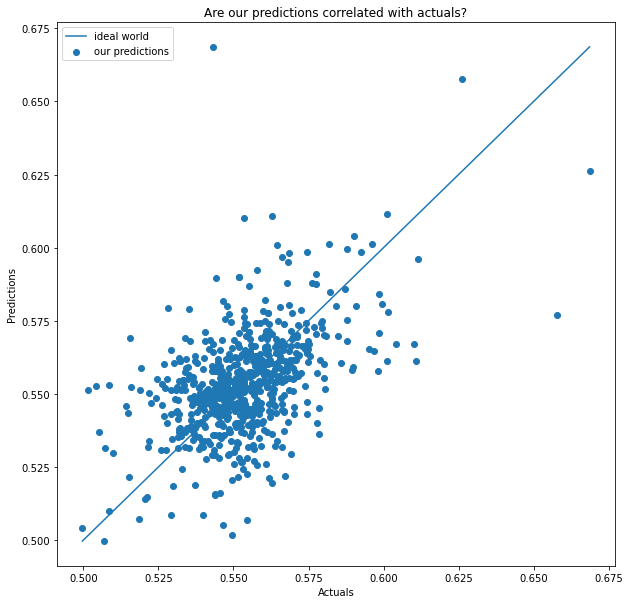

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(y, pred, label="our predictions")
ax.set_title("Are our predictions correlated with actuals?")
ax.set_xlabel("Actuals")
ax.set_ylabel("Predictions")

plotmin = min(y)
plotmax = max(y)

ax.plot([plotmin, plotmax], [plotmin, plotmax], label="ideal world")

plt.legend()
plt.show()

The second thing we can check is that the error terms are normally distributed (it helps us mathematically, and the central limit theorem). We can statistically test this with an Anderson-Darling test but looking at the histogram is a good place to start.

C:\Users\rachel.hassall\.conda\envs\charterful\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


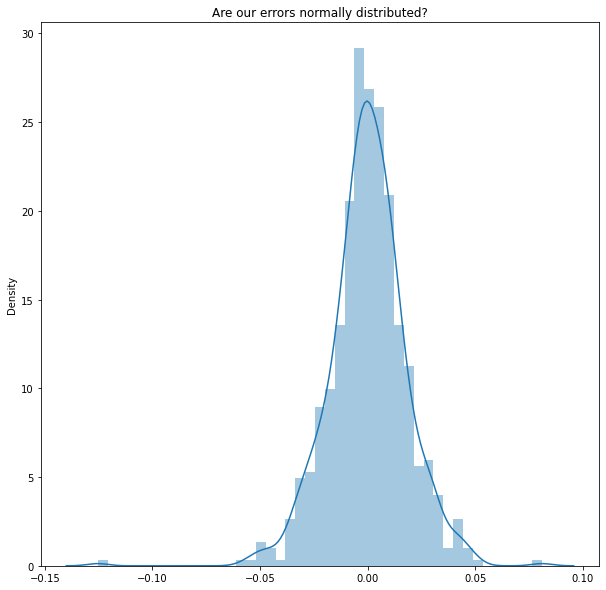

In [114]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.distplot(y - pred, ax=ax)
ax.set_title("Are our errors normally distributed?")
plt.show()

We also want the errors to be consistently random in time (constant variance), again we can look at a nice plot to check this.

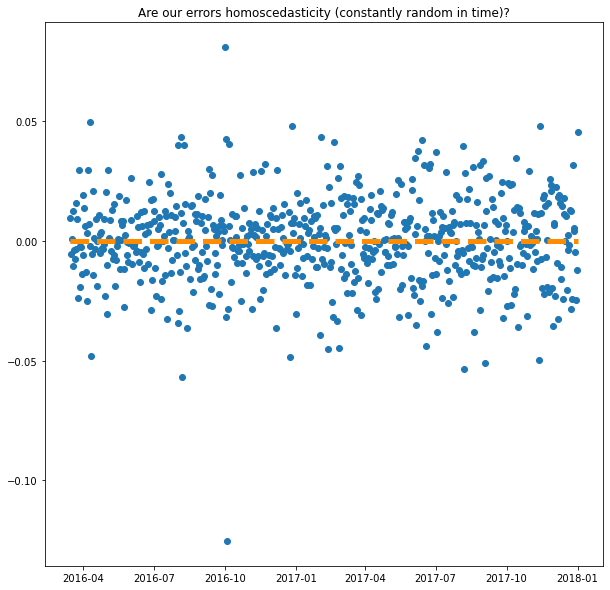

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Are our errors homoscedasticity (constantly random in time)?")
ax.scatter(pred.index, y - pred, label="Residuals (errors)")
ax.hlines(
    0, pred.index.min(), pred.index.max(), color="darkorange", linestyle="--", lw=5
)
plt.show()

A final check on the errors (residuals) is to ensure they perform evenly across the prediction space. We don't want to see any patterns (clusters, relationships etc.) here.

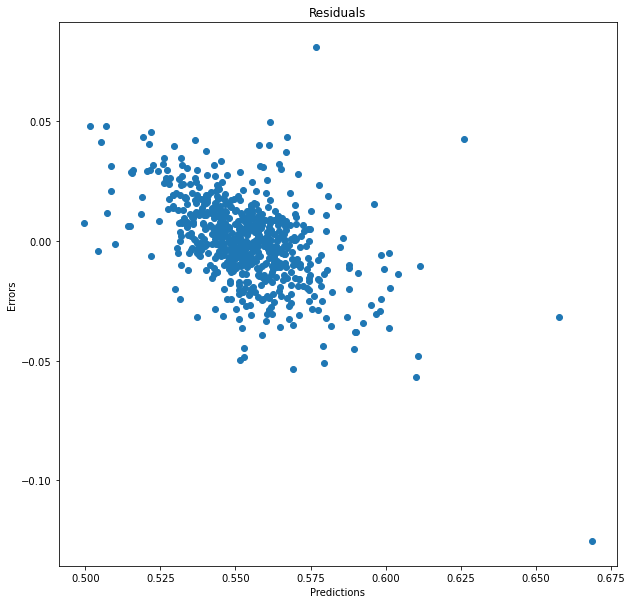

In [129]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Residuals")
ax.scatter(pred, y - pred, label="Residuals")
ax.set_ylabel("Errors")
ax.set_xlabel("Predictions")
plt.show()

In [126]:
def plot_evaluation(y, pred):
    """
    Various plots to explore model performance
    
    1. Residuals
    2. Actual v Prediction correlations
    3. Are errors random?
    4. Are errors normally distributed?
    
    """

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    # general predictions and actuals over time
    ax[0, 0].set_title("Residuals")
    ax[0, 0].scatter(pred, y - pred, label="Residuals")

    # correlation between predictions and actuals
    ax[0, 1].set_title("Are our predictions correlated with actuals?")
    ax[0, 1].scatter(y, pred, label="our predictions")
    ax[0, 1].set_xlabel("Actuals")
    ax[0, 1].set_ylabel("Predictions")
    plotmin = min(y)
    plotmax = max(y)
    ax[0, 1].plot([plotmin, plotmax], [plotmin, plotmax], label="ideal world")
    ax[0, 1].legend()

    # errors normally distributed
    ax[1, 1].set_title("Are our errors normally distributed?")
    sns.distplot(y - pred, ax=ax[1, 1])

    # errors constantly random over time
    ax[1, 0].set_title("Are our errors homoscedasticity (constantly random in time)?")
    ax[1, 0].scatter(pred.index, y - pred, label="Residuals (errors)")
    ax[1, 0].hlines(
        0, pred.index.min(), pred.index.max(), color="darkorange", linestyle="--", lw=5
    )

    plt.legend()
    plt.show()

We can summarise those plots and checks in one figure as below. It looks like our baseline does pretty well!

C:\Users\rachel.hassall\.conda\envs\charterful\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


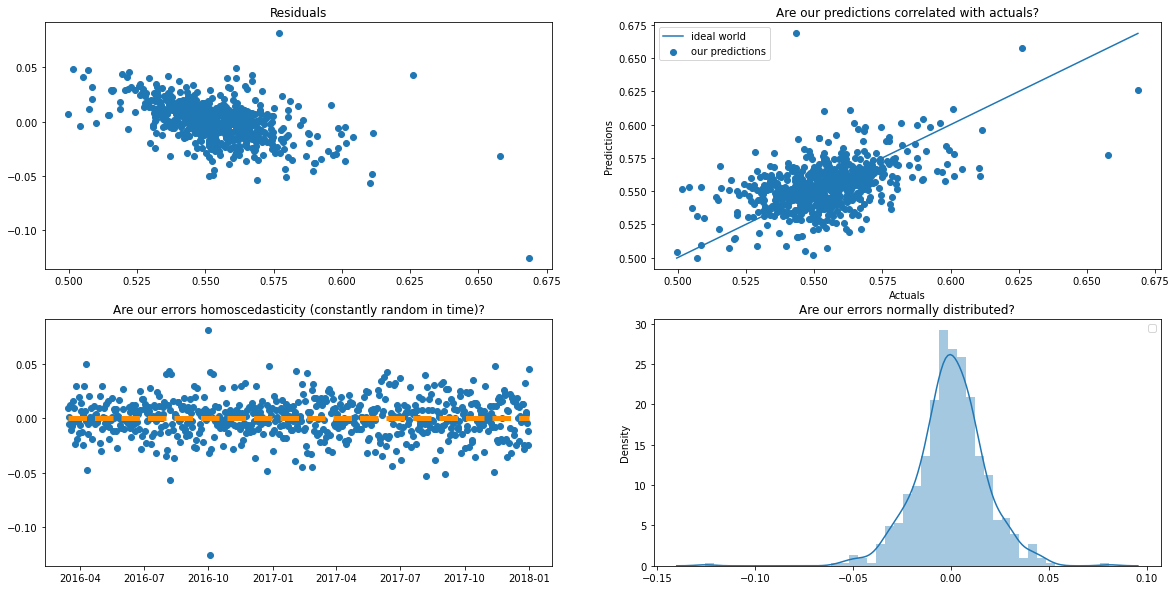

In [127]:
plot_evaluation(y, pred)

## Panel Regression

## Evaluation